# Cuda Practice on a Linear Network

## Fashion MNIST Dataset Download Commands

In [1]:
# Note: Forwarded stderr to /dev/null so no output will be shown but it works! :)
!wget -O train-images-idx3-ubyte.gz http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz 2> /dev/null
!wget -O train-labels-idx1-ubyte.gz http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz 2> /dev/null
!wget -O t10k-images-idx3-ubyte.gz http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz 2> /dev/null
!wget -O t10k-labels-idx1-ubyte.gz http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz 2> /dev/null

## Libraries

In [10]:
# -*- coding: utf-8 -*-
import os
import gzip
import torch as th
import numpy as np
import matplotlib.pyplot as plt
import argparse
import timeit

## Function that Loads Dataset

In [3]:
def load_mnist(dataset="training", path="."):
    if dataset not in  ['training', 'testing']:
        raise ValueError("dataset has to be either 'training' or 'testing'")

    if dataset == 'training':
        kind = 'train'
    else:
        kind = 't10k'

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz' % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8).astype(np.float32)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 28, 28).astype(np.float32)

    return th.from_numpy(images), th.from_numpy(labels)

## Dataset Class, Network Class, Train and Evaluate Function

In [17]:
class DatasetFashion():
    def __init__(self, option, crossvalidation=None, shuffle_mask=None, split_ratio=0.8, path='./'):
        
        if option=="testing":
                X,y = load_mnist("testing", path)
        else:
                X,y = load_mnist("training", path)

        self.images = X.reshape([-1, 28*28])
        self.images = self.images/255.0
        self.labels = y.type(th.long)
        self.shuffle_mask = shuffle_mask
        self.split_ratio = split_ratio

        if option=="training":
                
                # shuffle the data before splitting
                indices = th.randperm(len(self.labels))
                self.images = self.images[indices]
                self.labels = self.labels[indices]

                self.shuffle_mask = indices

                if crossvalidation:
                        splitSize = len(self.labels)//crossvalidation[0]
                        chunks = th.split(th.arange(len(self.labels)), splitSize, dim=0)
                        validation = chunks[crossvalidation[1]]
                        training = th.cat([c for j, c in enumerate(chunks) if j!=crossvalidation[1]], dim=0)
                        self.validationImages = self.images[validation]
                        self.validationLabels = self.labels[validation]
                        self.trainingImages = self.images[training]
                        self.trainingLabels = self.labels[training]
                
                else:
                        #split the data
                        split_value = int(len(self.images)*split_ratio)

                        self.images = self.images[:split_value]
                        self.labels = self.labels[:split_value]

        elif option=="validation":
                self.images = self.images[shuffle_mask]
                self.labels = self.labels[shuffle_mask]
                print("len: ", len(self.images))

                #split the data
                split_value = int(len(self.images)*(split_ratio))
                print("split_value= ", split_value)

                self.images = self.images[split_value:]
                self.labels = self.labels[split_value:]
                     
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

class Network(th.nn.Module):
    def __init__(self, num_inputs, num_classes, num_neurons=(50,50), activation=[th.nn.Sigmoid(),th.nn.Sigmoid()]):
        super(Network, self).__init__()
        self.activation = activation
        
        self.layers = th.nn.ModuleList()
        self.layers.append(th.nn.Linear(num_inputs, num_neurons[0], True))
        self.layers.append(activation[0])
        for i in range(len(num_neurons)-1):
            self.layers.append(th.nn.Linear(num_neurons[i], num_neurons[i+1], True))
            self.layers.append(activation[i+1])
        self.layers.append(th.nn.Linear(num_neurons[-1], num_classes, True))
        self.layers.append(th.nn.LogSoftmax(dim=1))   # If CrossEntropyLoss function is used as loss function, CrossEntropyLoss takes care of both logSoftmax and NLL loss
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

"""
reg_type   regularization type: l1 or l2
"""
def train(model, dataloader, optimizer, lossFunc, device = th.device('cpu'), debug=False):
    
    loss_hist = np.array([])
    for index, (trainingImages,trainingLabels) in enumerate(dataloader):
        optimizer.zero_grad()

        trainingImages = trainingImages.to(device, non_blocking=True)
        trainingLabels = trainingLabels.to(device, non_blocking=True)

        prediction = model(trainingImages.reshape(-1, 28*28))

        loss = lossFunc(prediction, trainingLabels)
        
        loss_hist = np.append(loss_hist, loss.item())
        loss.backward()
        optimizer.step()
        if debug:
            with th.no_grad():
                if index % 100 == 0:
                    print('Train {}/{} Loss {:.6f}'.format(index, len(dataloader), loss.item()))
    return loss_hist

def evaluate(model, val_dataloader, lossFunction, device = th.device('cpu')):

    total_loss = 0
    total_accuracy = 0
    for (val_images, val_labels) in val_dataloader:

        val_images = val_images.to(device, non_blocking=True)
        val_labels = val_labels.to(device, non_blocking=True)

        prediction = model(val_images.reshape(-1, 28*28))
        loss = lossFunction(prediction, val_labels.squeeze()).item() / len(val_images)
        total_loss += loss

        pred_label = th.argmax(prediction, dim=1)
        #print("----------", pred_label[0:10], labels.squeeze()[0:10], pred_label[0:10] == labels.squeeze()[0:10])
        accuracy = ((pred_label == val_labels).sum().item()) / len(val_images)
        #accuracy = th.sum(pred_label == labels.squeeze()) / len(labels)
        total_accuracy += accuracy

    avg_loss = total_loss / len(val_dataloader)
    avg_accuracy = total_accuracy / len(val_dataloader)
    return avg_loss, avg_accuracy

In [5]:
model = Network(28*28, 10, num_neurons=(50,150), activation=[th.nn.Sigmoid(), th.nn.Sigmoid()])
for name, param in model.named_parameters():
    if 'bias' not in name:
        print(param.shape)

torch.Size([50, 784])
torch.Size([150, 50])
torch.Size([10, 150])


48000
torch.Size([1, 784])
torch.Size([1, 784])


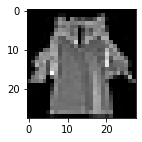

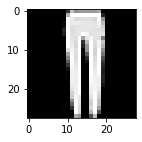

In [16]:
dataset = DatasetFashion(option="training")
print(len(dataset))
dataloader = th.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

for index, (images,labels) in enumerate(dataloader):
    print(images.shape)
    plt.figure(figsize=(2,2))
    plt.imshow(images.reshape(28,28), cmap='gray')
    if index == 1:
        break

## Device Settings

In [14]:
disable_cuda = False    # a=> args.disable_cuda

if not disable_cuda and th.cuda.is_available():
    device = th.device('cuda')
else:
    device = th.device('cpu')

print(device)

print("device count: ", th.cuda.device_count())

cuda
device count:  1


## With Cuda

len:  60000
split_value=  48000
epoch  1  validation loss:  0.07196961494286855  validation accuracy:  0.09925
epoch  2  validation loss:  0.07196016923586528  validation accuracy:  0.09875
epoch  3  validation loss:  0.07194259963432947  validation accuracy:  0.10625
epoch  4  validation loss:  0.07195240147908528  validation accuracy:  0.09533333333333334
epoch  5  validation loss:  0.07195836665232977  validation accuracy:  0.09533333333333334
epoch  6  validation loss:  0.07193348968029022  validation accuracy:  0.0975
epoch  7  validation loss:  0.0719167846639951  validation accuracy:  0.09533333333333334
epoch  8  validation loss:  0.07188027717669805  validation accuracy:  0.09816666666666667
epoch  9  validation loss:  0.07190444626410802  validation accuracy:  0.09533333333333334
epoch  10  validation loss:  0.07185791995127996  validation accuracy:  0.09875
epoch  11  validation loss:  0.07182767536242803  validation accuracy:  0.13866666666666666
epoch  12  validation loss:

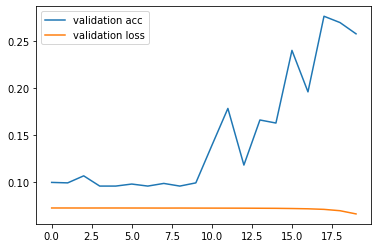

In [18]:
batch_size = 32

train_dataset = DatasetFashion(option="training")
dataloader = th.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

val_dataset = DatasetFashion(option="validation", shuffle_mask=train_dataset.shuffle_mask)
val_dataloader = th.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

lossFunction = th.nn.NLLLoss()

model = Network(num_inputs=28*28, num_classes=10, num_neurons=(50,50,50), activation=[th.nn.Sigmoid(),th.nn.Sigmoid(),th.nn.Sigmoid()]).to(device=device)

optimizer = th.optim.SGD(model.parameters(), lr=0.005)

epoch = 20

start = timeit.default_timer()

loss_hist = np.array([])   
val_loss_hist = np.array([])
val_acc_hist = np.array([])
for i in range(epoch):
    #training
    loss_hist_per_epoch = train(model, dataloader, optimizer, lossFunction, device=device, debug=False)
    #evaluation
    avg_loss, avg_accuracy = evaluate(model, val_dataloader, lossFunction, device=device)

    #loss and accuracy histories are kept
    loss_hist = np.hstack((loss_hist, loss_hist_per_epoch))
    val_loss_hist = np.hstack((val_loss_hist, avg_loss))
    val_acc_hist = np.hstack((val_acc_hist, avg_accuracy))

    print("epoch ", i+1, " validation loss: ", avg_loss, " validation accuracy: ", avg_accuracy)

stop = timeit.default_timer()
print('Time: ', stop - start) 

plt.plot(val_acc_hist, label="validation acc")
plt.plot(val_loss_hist, label="validation loss")
plt.legend()

## Without CUDA

len:  60000
split_value=  48000
epoch  1  validation loss:  0.07198342682917913  validation accuracy:  0.09791666666666667
epoch  2  validation loss:  0.07196305032571157  validation accuracy:  0.10341666666666667
epoch  3  validation loss:  0.07195813467105229  validation accuracy:  0.09258333333333334
epoch  4  validation loss:  0.07196012339989344  validation accuracy:  0.0925
epoch  5  validation loss:  0.07193929086128871  validation accuracy:  0.0925
epoch  6  validation loss:  0.07193459379673005  validation accuracy:  0.10225
epoch  7  validation loss:  0.07192509041229884  validation accuracy:  0.1135
epoch  8  validation loss:  0.071922693947951  validation accuracy:  0.09866666666666667
epoch  9  validation loss:  0.07190870716174444  validation accuracy:  0.10108333333333333
epoch  10  validation loss:  0.07190073299407959  validation accuracy:  0.09908333333333333
epoch  11  validation loss:  0.07186176045735677  validation accuracy:  0.11866666666666667
epoch  12  validat

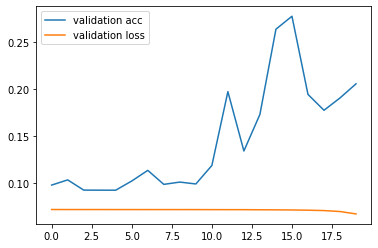

In [19]:
batch_size = 32

train_dataset = DatasetFashion(option="training")
dataloader = th.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DatasetFashion(option="validation", shuffle_mask=train_dataset.shuffle_mask)
val_dataloader = th.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

lossFunction = th.nn.NLLLoss()

device = th.device('cpu')

model = Network(num_inputs=28*28, num_classes=10, num_neurons=(50,50,50), activation=[th.nn.Sigmoid(),th.nn.Sigmoid(),th.nn.Sigmoid()]).to(device=device)

optimizer = th.optim.SGD(model.parameters(), lr=0.005)

epoch = 20

start = timeit.default_timer()

loss_hist = np.array([])   
val_loss_hist = np.array([])
val_acc_hist = np.array([])
for i in range(epoch):
    #training
    loss_hist_per_epoch = train(model, dataloader, optimizer, lossFunction, device=device, debug=False)
    #evaluation
    avg_loss, avg_accuracy = evaluate(model, val_dataloader, lossFunction, device=device)

    #loss and accuracy histories are kept
    loss_hist = np.hstack((loss_hist, loss_hist_per_epoch))
    val_loss_hist = np.hstack((val_loss_hist, avg_loss))
    val_acc_hist = np.hstack((val_acc_hist, avg_accuracy))

    print("epoch ", i+1, " validation loss: ", avg_loss, " validation accuracy: ", avg_accuracy)

stop = timeit.default_timer()
print('Time: ', stop - start) 

plt.plot(val_acc_hist, label="validation acc")
plt.plot(val_loss_hist, label="validation loss")
plt.legend()

## Why this result occured?

Since this network is small and the dataset is not big, GPU performance differences could not be observed. Therefore, transfer times to GPU caused spending more time.

## Example Usage of CUDA

In [27]:
net = Network(num_inputs=28*28, num_classes=10).to(device=device)

dataset = DatasetFashion(option="training")
dataloader = th.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

cuda0 = th.device('cuda:0')  # CUDA GPU 0
for i, (images, labels) in enumerate(dataloader):
    images = images.to(cuda0)
    labels = labels.to(cuda0)